In [1]:
1

1

In [1]:
import numpy as np
U_pred_0 = np.load("/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthOrderPDE_PinnSymReg/Cos/Train/U_pred.npy")
U_pred_1= np.load("/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthOrderPDE_PinnSymReg/Exp/Train/U_pred.npy")
U_pred_2=np.load("/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthOrderPDE_PinnSymReg/Combined/Train/U_pred.npy")

f= np.load("/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthEvoPINN/Sin/Train/f.npy")
t=np.linspace(0,1,500).reshape(-1,1)
x=np.linspace(-1,1,500).reshape(-1,1)
xx, tt = np.meshgrid(x, t)
X = np.vstack((np.ravel(xx), np.ravel(tt))).T

In [2]:
import pandas as pd

# Assuming you have already computed U_pred
data0 = {'x': xx.flatten(), 't': tt.flatten(), 'type': [0] * len(xx.flatten()),'U_pred': U_pred_0.flatten()}
df0 = pd.DataFrame(data0)
data1 = {'x': xx.flatten(), 't': tt.flatten(), 'type': [1] * len(xx.flatten()),'U_pred': U_pred_1.flatten()}
df1 = pd.DataFrame(data1)
data2 = {'x': xx.flatten(), 't': tt.flatten(), 'type': [2] * len(xx.flatten()),'U_pred': U_pred_2.flatten()}
df2= pd.DataFrame(data2)



In [3]:
# Concatenate the DataFrames
df_combined = pd.concat([df0, df1, df2], ignore_index=True)

# Print the combined DataFrame
print(df_combined)
# Save the combined DataFrame as CSV
df_combined.to_csv('/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthOrderPDE_PinnSymReg/combined_data_solution.csv', index=False)



               x    t  type    U_pred
0      -1.000000  0.0     0 -0.950177
1      -0.995992  0.0     0 -0.942597
2      -0.991984  0.0     0 -0.935025
3      -0.987976  0.0     0 -0.927461
4      -0.983968  0.0     0 -0.919906
...          ...  ...   ...       ...
749995  0.983968  1.0     2 -0.999043
749996  0.987976  1.0     2 -1.002808
749997  0.991984  1.0     2 -1.006585
749998  0.995992  1.0     2 -1.010374
749999  1.000000  1.0     2 -1.014175

[750000 rows x 4 columns]


In [24]:
df_combined.sample(10)

,x,t,type,U_pred
663339,0.358717,0.653307,2,-0.352263
580566,-0.735471,0.322645,2,-0.562299
90753,0.014028,0.362725,0,-0.341481
15584,-0.663327,0.062124,0,-0.417937
541633,-0.466934,0.166333,2,0.000666
693018,-0.927856,0.773547,2,-0.942017
496402,0.611222,0.985972,1,0.111117
627604,-0.583166,0.511022,2,-0.490955
121972,0.891784,0.486974,0,-0.902583
389209,-0.162325,0.557114,1,0.239757


In [26]:
from sklearn.model_selection import train_test_split

# Combine data with type information
df_combined['type'] = df_combined['type'].astype('category')

# Split data into features (X) and target (y)
X = df_combined[['x', 't', 'type']]
y = df_combined['U_pred']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Encode categorical variable 'type'
X_train_encoded = pd.get_dummies(X_train, columns=['type'])
X_test_encoded = pd.get_dummies(X_test, columns=['type'])


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Encode categorical variable 'type'
X_train_encoded = pd.get_dummies(X_train, columns=['type'])
X_test_encoded = pd.get_dummies(X_test, columns=['type'])

# Build and compile the DNN model
model_dnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_encoded.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_dnn.compile(optimizer='adam', loss='mse')

# Train the DNN model
model_dnn.fit(X_train_encoded, y_train, epochs=50, batch_size=32, validation_split=0.2)


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
import numpy as np

# Define R^2 metric function
def r_square(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return 1 - SS_res/(SS_tot + tf.keras.backend.epsilon())

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)

# Build and compile the DNN model
model_dnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_encoded.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_dnn.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse', r_square])

# Train the DNN model with early stopping
history = model_dnn.fit(X_train_encoded, y_train, epochs=100, batch_size=32, 
                        validation_split=0.2, callbacks=[early_stopping])

# Evaluate the DNN model on test data
loss, mae, mse, r2 = model_dnn.evaluate(X_test_encoded, y_test)

print("DNN - MAE:", mae)
print("DNN - MSE:", mse)
print("DNN - R^2:", r2)

# Save the DNN model
model_dnn.save("model_dnn.h5")




Epoch 1/100


/home/trl102/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


12000/12000 [==============================] - 21s 2ms/step - loss: 0.0185 - mae: 0.0433 - mse: 0.0185 - r_square: -10.5455 - val_loss: 1.7109e-04 - val_mae: 0.0094 - val_mse: 1.7109e-04 - val_r_square: 0.8972
Epoch 2/100
12000/12000 [==============================] - 20s 2ms/step - loss: 2.0815e-04 - mae: 0.0098 - mse: 2.0815e-04 - r_square: 0.8748 - val_loss: 2.4770e-04 - val_mae: 0.0109 - val_mse: 2.4770e-04 - val_r_square: 0.8323
Epoch 3/100
12000/12000 [==============================] - 20s 2ms/step - loss: 1.4218e-04 - mae: 0.0079 - mse: 1.4218e-04 - r_square: 0.9139 - val_loss: 6.9831e-05 - val_mae: 0.0052 - val_mse: 6.9831e-05 - val_r_square: 0.9571
Epoch 4/100
12000/12000 [==============================] - 20s 2ms/step - loss: 1.2860e-04 - mae: 0.0073 - mse: 1.2860e-04 - r_square: 0.9235 - val_loss: 6.9056e-05 - val_mae: 0.0051 - val_mse: 6.9056e-05 - val_r_square: 0.9576
Epoch 5/100
12000/12000 [==============================] - 19s 2ms/step - loss: 1.1630e-04 - mae: 0.0068 -

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest model
model_rf = RandomForestRegressor(n_estimators=50, random_state=42)
model_rf.fit(X_train_encoded, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [9]:
# Predictions from DNN
#y_pred_dnn = model_dnn.predict(X_test_encoded).flatten()

# Predictions from Random Forest
y_pred_rf = model_rf.predict(X_test_encoded)


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate metrics for DNN
#mae_dnn = mean_absolute_error(y_test, y_pred_dnn)
#mse_dnn = mean_squared_error(y_test, y_pred_dnn)

# Calculate metrics for Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

#print("DNN - MAE:", mae_dnn)
#print("DNN - MSE:", mse_dnn)
print("Random Forest - MAE:", mae_rf)
print("Random Forest - MSE:", mse_rf)


Random Forest - MAE: 0.00027854650959659773
Random Forest - MSE: 2.0891832080276308e-07


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics for DNN
#mae_dnn = mean_absolute_error(y_test, y_pred_dnn)
#mse_dnn = mean_squared_error(y_test, y_pred_dnn)
#r2_dnn = r2_score(y_test, y_pred_dnn)

# Calculate metrics for Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

#print("DNN - MAE:", mae_dnn)
#print("DNN - MSE:", mse_dnn)
#print("DNN - R^2:", r2_dnn)

print("Random Forest - MAE:", mae_rf)
print("Random Forest - MSE:", mse_rf)
print("Random Forest - R^2:", r2_rf)


Random Forest - MAE: 0.00027854650959659773
Random Forest - MSE: 2.0891832080276308e-07
Random Forest - R^2: 0.9999989531133993


In [12]:
 #Get feature importances
feature_importances = model_rf.feature_importances_
print("Feature Importances:", feature_importances)

Feature Importances: [0.22742393 0.18753277 0.03598428 0.52556285 0.02349618]


In [13]:
# First, ensure joblib is installed
!pip install joblib


In [14]:
pwd

'/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthOrderPDE_PinnSymReg/MLandSymReg'

In [15]:
import joblib

# Save the model to a file
joblib.dump(model_rf, 'Random_forest_model.pkl')  # The file will be saved as 'random_forest_model.pkl'


['Random_forest_model.pkl']

In [16]:
# Load the model from the file
model_rf_loaded = joblib.load('Random_forest_model.pkl')

# Test if the loaded model works (for example, on the test set)
predictions = model_rf_loaded.predict(X_test_encoded)  # X_test_encoded is your test data

# Do something with the predictions
print(predictions)


[ 0.20558092  0.07544372 -0.34316651 ... -0.50495418  0.13828602
  0.1985154 ]


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics for DNN
#mae_dnn = mean_absolute_error(y_test, y_pred_dnn)
#mse_dnn = mean_squared_error(y_test, y_pred_dnn)
#r2_dnn = r2_score(y_test, y_pred_dnn)

y_pred_rf = predictions

# Calculate metrics for Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

#print("DNN - MAE:", mae_dnn)
#print("DNN - MSE:", mse_dnn)
#print("DNN - R^2:", r2_dnn)

print("Random Forest - MAE:", mae_rf)
print("Random Forest - MSE:", mse_rf)
print("Random Forest - R^2:", r2_rf)


Random Forest - MAE: 0.00027854650959659773
Random Forest - MSE: 2.0891832080276308e-07
Random Forest - R^2: 0.9999989531133993


In [33]:

model_rf=model_rf_loaded

# Define the grid for prediction
t_values = np.linspace(0, 1, 500)
x_values = np.linspace(-1, 1, 500)
xx, tt = np.meshgrid(x_values, t_values)

# Ensure consistent features with dummy encoding
# Create the prediction grid with 'type' set to 0
X_grid = np.column_stack((xx.flatten(), tt.flatten(), np.zeros(xx.flatten().shape)))  # 'type' is 0

# Convert to DataFrame
X_grid_df = pd.DataFrame(X_grid, columns=['x', 't', 'type'])

# Encode 'type' as dummy variables
X_grid_encoded = pd.get_dummies(X_grid_df, columns=['type'])

# Create dummy columns for any missing types (fill with 0)
expected_columns = ['x', 't', 'type_0', 'type_1', 'type_2']
for col in expected_columns:
    if col not in X_grid_encoded:
        X_grid_encoded[col] = 0  # Add missing feature with default value

# Reorder columns to match expected order
X_grid_encoded = X_grid_encoded[expected_columns]

# Predict the solution with the existing model
U_pred = model_rf.predict(X_grid_encoded).reshape(xx.shape)


In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use('pgf')
import tensorflow as tf
import numpy as np
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

2024-05-06 19:25:08.478702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 19:25:08.832731: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 19:25:12.007468: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/trl102/miniconda3/envs/tf/lib/
2024-05-06 19:25:12.008497: W tensorflow/compiler

In [37]:
pwd

'/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthOrderPDE_PinnSymReg/MLandSymReg'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


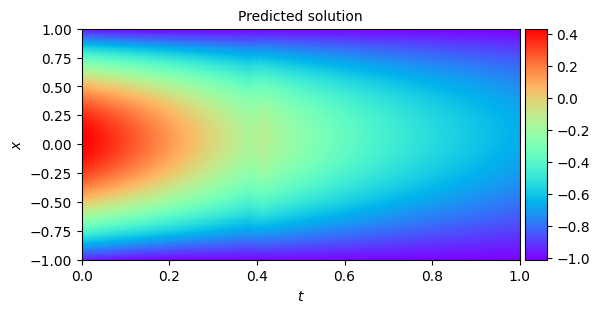

In [38]:
import matplotlib.gridspec as gridspe
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(6, 3))

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
line = np.linspace(x.min(), x.max(), 2)[:,None]

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('Predicted solution', fontsize = 10)

plt.savefig('W_2d_type_0.eps',dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


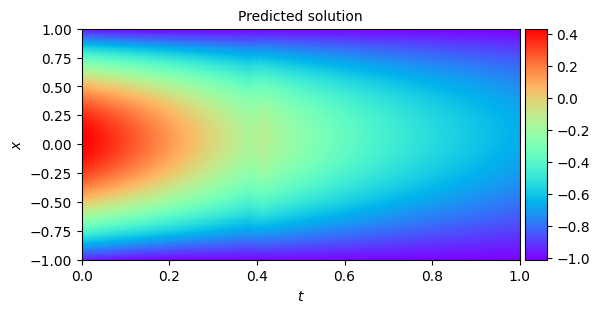

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import joblib

# Load the pre-trained model
model_rf = joblib.load('Random_forest_model.pkl')

# Define the grid
t_values = np.linspace(0, 1, 500)
x_values = np.linspace(-1, 1, 500)
xx, tt = np.meshgrid(x_values, t_values)

# Create a 2D array for prediction with 'type' set to 1
X_grid = np.column_stack((xx.flatten(), tt.flatten(), np.ones(xx.flatten().shape)))  # 'type' is 1

# Encode 'type' and ensure all expected columns
X_grid_encoded = pd.get_dummies(pd.DataFrame(X_grid, columns=['x', 't', 'type']), columns=['type'])

# Make sure all expected columns are present
expected_columns = ['x', 't', 'type_0', 'type_1', 'type_2']
for col in expected_columns:
    if col not in X_grid_encoded:
        X_grid_encoded[col] = 0  # Add missing feature with default value

# Reorder columns to match expected order
X_grid_encoded = X_grid_encoded[expected_columns]

# Predict and reshape
U_pred = model_rf.predict(X_grid_encoded).reshape(xx.shape)

# Plotting the predicted solution for 'type 1'
fig, ax = plt.subplots(figsize=(6, 3))
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
line = np.linspace(x.min(), x.max(), 2)[:,None]

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('Predicted solution', fontsize = 10)

plt.savefig('W_2d_comb.eps',dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


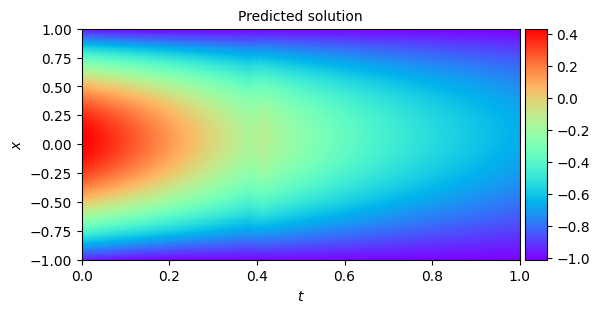

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import joblib

# Load the pre-trained model
model_rf = joblib.load('Random_forest_model.pkl')

# Define the prediction grid
t_values = np.linspace(0, 1, 500)
x_values = np.linspace(-1, 1, 500)
xx, tt = np.meshgrid(x_values, t_values)

# Create a 2D array for prediction with 'type' set to 2
X_grid = np.column_stack((xx.flatten(), tt.flatten(), np.full(xx.flatten().shape, 2)))  # 'type' is 2

# Encode 'type' and ensure all expected columns
X_grid_encoded = pd.get_dummies(pd.DataFrame(X_grid, columns=['x', 't', 'type']), columns=['type'])

# Make sure all expected columns are present
expected_columns = ['x', 't', 'type_0', 'type_1', 'type_2']
for col in expected_columns:
    if col not in X_grid_encoded:
        X_grid_encoded[col] = 0  # Add missing features with a default value

# Reorder columns to match expected order
X_grid_encoded = X_grid_encoded[expected_columns]

# Plotting the predicted solution for 'type 1'
fig, ax = plt.subplots(figsize=(6, 3))
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
line = np.linspace(x.min(), x.max(), 2)[:,None]

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('Predicted solution', fontsize = 10)

plt.savefig('W_2d_comb.eps',dpi=300)
plt.show()


Text(0.5, 0, '$t$')

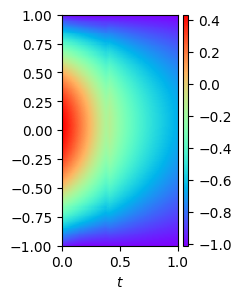

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import joblib

# Load the pre-trained Random Forest model
model_rf = joblib.load('Random_forest_model.pkl')  # Change to your saved model's path

# Define the prediction grid
t_values = np.linspace(0, 1, 500)
x_values = np.linspace(-1, 1, 500)
xx, tt = np.meshgrid(x_values, t_values)

# Create a 2D array for prediction with 'type' set to 0
X_grid = np.column_stack((xx.flatten(), tt.flatten(), np.zeros(xx.flatten().shape)))  # 'type' is 0

# One-hot encode 'type' and ensure expected columns
X_grid_encoded = pd.get_dummies(pd.DataFrame(X_grid, columns=['x', 't', 'type']), columns=['type'])

# Ensure all expected columns are present
expected_columns = ['x', 't', 'type_0', 'type_1', 'type_2']
for col in expected_columns:
    if col not in X_grid_encoded:
        X_grid_encoded[col] = 0  # Add missing columns with default value

# Reorder columns to match the expected order
X_grid_encoded = X_grid_encoded[expected_columns]

# Predict the solution with the pre-trained Random Forest model
U_pred = model_rf.predict(X_grid_encoded).reshape(xx.shape)

# Plotting the predicted solution for 'type 0'
fig, ax = plt.subplots(figsize=(6, 3))
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t_values.min(), t_values.max(), x_values.min(), x_values.max()],
              origin='lower')

# Add a colorbar to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# Set plot labels and title
ax.set_xlabel('$t$')



In [1]:
!pip install -U pysr

In [3]:
import pysr

In [4]:
import pandas as pd

In [59]:
df1=pd.read_csv("/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthEvoPINN/SymbolicReg/solitary.csv")
X = df1[['t','x']].values
y = df1['U_pred'].values

In [67]:
X[:,0]

array([0., 0., 0., ..., 2., 2., 2.])

In [5]:
df1=pd.read_csv("/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthEvoPINN/SymbolicReg/solitary.csv")
X = df1[['t','x']].values
y = df1['U_pred'].values
import sympy
import numpy as np
import pandas as pd
#from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
default_pysr_params = dict(
    populations=30,
    model_selection="best",
)

model = PySRRegressor(
    niterations=30,
    batching=True,
    batch_size=128,
    fast_cycle=True,
    binary_operators=["+", "*"],
    unary_operators=["cos", "exp", "sin", "quart(x) = x^4","inv(x)=x^-1"],
    extra_sympy_mappings={"quart": lambda x: x**4,"inv": lambda x: 1/x}, **default_pysr_params,
)
model.fit(X, y)

In [7]:
solitary.csv

array([[  0.        , -30.        ],
       [  0.        , -29.93993994],
       [  0.        , -29.87987988],
       ...,
       [  2.        ,  29.87987988],
       [  2.        ,  29.93993994],
       [  2.        ,  30.        ]])

In [12]:
X.shape

(200000, 2)

In [9]:
y

array([-0.00343278, -0.00334099, -0.00344631, ...,  0.00013268,
        0.00028506,  0.00037002])

In [44]:
df1['t'].values

array([0., 0., 0., ..., 2., 2., 2.])

In [45]:
sorted_list = sorted(df1['t'].values, reverse=True)

# Get the five largest elements using slicing
five_largest = sorted_list[:5]

print("Five largest elements:", five_largest)

Five largest elements: [2.0, 2.0, 2.0, 2.0, 2.0]


(array([20000., 20000., 20000., 20000., 20000., 20000., 20000., 20000.,
        20000., 20000.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

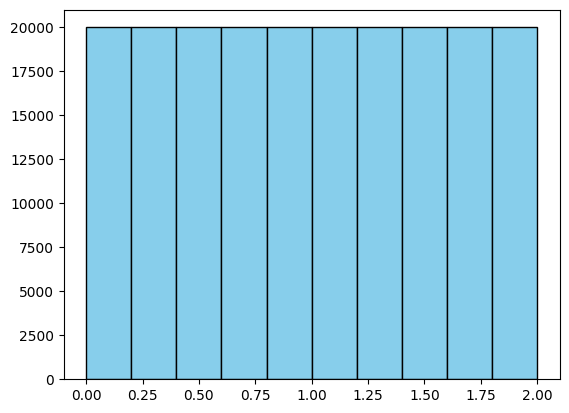

In [43]:
import matplotlib.pyplot as plt
plt.hist(df1['t'], bins=10, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed


In [99]:
import sympy as sp
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

# Load your data
df1 = pd.read_csv("/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthEvoPINN/SymbolicReg/BurgerData.csv")

# Extract features and target variable
X_raw = df1[['x', 't']].values
y = df1['U_pred'].values

# Normalize features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

# Fit the PySR model
model = PySRRegressor(
    niterations=50,
    batching=True,
    batch_size=264,
    elementwise_loss="L2EpsilonInsLoss(0.000001)",
    fast_cycle=True,
    binary_operators=["+", "*"],
    unary_operators=["cos", "exp", "sin", "quart(x) = x^4", "inv(x)=x^-1"],
    extra_sympy_mappings={"quart": lambda x: x**4, "inv": lambda x: 1/x},
    populations=40,
   
)
model.fit(X_scaled, y)


/home/trl102/miniconda3/envs/tf/lib/python3.9/site-packages/pysr/sr.py:1302: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 5.520e+02
Head worker occupation: 15.6%
Progress: 49 / 2000 total iterations (2.450%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           4.391e-03  7.971e+00  y = quart(0.35803)
3           4.391e-03  5.901e-06  y = -0.63011 * -0.026216
6           4.382e-03  6.396e-04  y = (sin(x₀) * -0.31957) * -0.076793
7           4.382e-03  1.788e-07  y = sin((sin(x₀) * -0.31957) * -0.076793)
8           4.230e-03  3.547e-02  y = sin(quart(sin(-0.41249) * sin(exp(x₀))))
9           3.436e-03  2.079e-01  y = quart(quart(sin(cos(sin(cos(2.8937 * x₀))))))
10          3.329e-03  3.141e-02  y = quart(quart(sin(sin(quart(exp(quart(x₀ + 0.034878)))))))
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 6.580e+02
Head work

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                        -0.24336375   
	1         2.796987                                 quart(-0.35924858)   
	2         0.001010                                   x0 * 0.027640369   
	3         0.005654                              0.031280544 * sin(x0)   
	4         0.003409                         sin(exp(x0)) * 0.024666425   
	5         0.027714                  0.031280544 * quart(sin(exp(x0)))   
	6         0.213472             quart(quart(sin(sin(x0 * 2.8544407))))   
	7         0.110756     quart(quart(sin(2.8655648 * x0))) * 0.10262304   
	8         0.322094  quart(sin(quart(quart(quart(sin(x0 * 2.847759)...   
	9   >>>>  1.834168  0.33527666 * quart(quart(quart(quart(sin(x0 * ...   
	10        0.000389  sin(quart(quart(quart(quart(sin(2.847759 * x0)...   
	11        0.079300  sin(quart(sin(quart(quart(quart(sin(2.8452857 ...   
	12        0.001275  0.66367424 * quart(sin(quart(quart(quart(sin((...   
	13        0.005735  sin(0.66406506 * quart(sin(quart(quart(quart(s...   
	14        0.006661  sin(0.687203 * sin(quart(sin(quart(quart(quart...   
	15        0.005789  sin(sin(quart(quart(quart(quart(sin((-1.107099...   
	16        0.004608  sin(sin(sin(sin(sin(quart(quart(quart(quart(si...   
	
	        loss  complexity  
	0   0.071987           1  
	1   0.004391           2  
	2   0.004386           3  
	3   0.004362           4  
	4   0.004347           5  
	5   0.004228           6  
	6   0.003415           7  
	7   0.003057           8  
	8   0.002215           9  
	9   0.000354          10  
	10  0.000354          11  
	11  0.000327          12  
	12  0.000326          15  
	13  0.000324          16  
	14  0.000322          17  
	15  0.000320          18  
	16  0.000318          19  
]

In [100]:
# Predict using the model on the normalized features
y_pred = model.predict(X_scaled)

# Calculate R^2 score
r2 = r2_score(y, y_pred)
print("R^2 score:", r2)

R^2 score: 0.9193975097054181


In [101]:
model.sympy()

0.33527666*sin(2.847759*x0)**256

In [91]:
model.latex_table()

'\\usepackage{breqn}\n\\usepackage{booktabs}\n\n...\n\n\\begin{table}[h]\n\\begin{center}\n\\begin{tabular}{@{}cccc@{}}\n\\toprule\nEquation & Complexity & Loss & Score \\\\\n\\midrule\n$y = x_{0}$ & $1$ & $0.319$ & $0.0$ \\\\\n$y = 0.0167$ & $2$ & $0.00438$ & $4.29$ \\\\\n$y = 0.0319 x_{0}$ & $3$ & $0.00438$ & $0.000508$ \\\\\n$y = 0.0319 \\sin{\\left(x_{0} \\right)}$ & $4$ & $0.00435$ & $0.00623$ \\\\\n\\begin{minipage}{0.8\\linewidth} \\vspace{-1em} \\begin{dmath*} y = 0.0393 \\sin{\\left(\\sin{\\left(x_{0} \\right)} \\right)} \\end{dmath*} \\end{minipage} & $5$ & $0.00434$ & $0.00382$ \\\\\n\\begin{minipage}{0.8\\linewidth} \\vspace{-1em} \\begin{dmath*} y = \\sin^{16}{\\left(\\sin{\\left(e^{x_{0}} \\right)} \\right)} \\end{dmath*} \\end{minipage} & $6$ & $0.00425$ & $0.0195$ \\\\\n$y = x_{0}^{4} \\sin^{16}{\\left(e^{x_{0}} \\right)}$ & $7$ & $0.00356$ & $0.177$ \\\\\n\\begin{minipage}{0.8\\linewidth} \\vspace{-1em} \\begin{dmath*} y = x_{0}^{4} \\cos^{4}{\\left(\\frac{1}{x_{0} - 0

In [24]:
default_pysr_params = dict(
    populations=40,
    model_selection="best",
)

In [25]:
X = 2 * np.random.randn(100, 5)
y = 2 * np.cos(X[:, 3]) + X[:, 0] ** 2 - 2
model = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*"],
    unary_operators=["cos", "exp", "sin"],
    **default_pysr_params,
)

model.fit(X, y)

/home/trl102/miniconda3/envs/tf/lib/python3.9/site-packages/pysr/sr.py:1302: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 6.600e+04
Head worker occupation: 93.3%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 133 / 1200 total iterations (11.083%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           5.538e+01  7.971e+00  y = exp(0.81799)
3           5.423e+01  2.097e-02  y = exp(cos(x₂))
4           3.284e+01  5.016e-01  y = exp(-0.55877 * x₀)
5           1.755e+00  2.929e+00  y = -1.783 + (x₀ * x₀)
7           1.740e+00  4.431e-03  y = ((x₀ + 0.093727) * x₀) + -1.783
8           4.392e-01  1.377e+00  y = -1.8726 + ((x₀ * x₀) + cos(x₃))
9           4.364e-01  6.429e-03  y = ((x₀ * x₀) + exp(cos(x₃))) + -2.8362
10          2.121e-01  7.217e-01  y = (cos(x₃) * 1.3052) + (-1.9113 + (x₀ * x₀))
11          4.320e-13  1.594e+01  y = (x₀ * x₀) + (cos(x₃) + (-2 + cos(x₃)))
15        

PySRRegressor.equations_ = [
	    pick      score                                           equation  \
	0          0.000000                                          1.2340871   
	1          0.019039                                    exp(0.81799436)   
	2          2.417831                                            x0 * x0   
	3          0.516816                              -1.782967 + (x0 * x0)   
	4          0.005266               -1.774737 + (x0 * (x0 + 0.06752318))   
	5          1.375763                 (cos(x3) + -1.8915536) + (x0 * x0)   
	6          0.252709            (exp(cos(x3)) + -3.1409526) + (x0 * x0)   
	7          4.322232   ((cos(x3) * 1.9148111) + -1.9541777) + (x0 * x0)   
	8         23.071904     (x0 * x0) + (cos(x3) + (-1.9999999 + cos(x3)))   
	9          0.109903  ((-1.9999999 + (x0 * x0)) + cos(x3)) + (cos(x3...   
	10  >>>>   0.083940  (cos(x3) + (-2.6704848 + cos(x3))) + ((x0 * x0...   
	
	            loss  complexity  
	0   5.644121e+01           1  
	1   5.537678e+01           2  
	2   4.934886e+00           3  
	3   1.755403e+00           5  
	4   1.737013e+00           7  
	5   4.388508e-01           8  
	6   3.408527e-01           9  
	7   4.523193e-03          10  
	8   4.319611e-13          11  
	9   3.467243e-13          13  
	10  2.278827e-13          18  
]

In [26]:
model.sympy()

x0**2 + 2*cos(x3) - 1.99999980220235

In [1]:
import sympy
import numpy as np
import pandas as pd
#from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

Detected Jupyter notebook. Loading juliacall extension. Set `PYSR_AUTOLOAD_EXTENSIONS=no` to disable.


In [ ]:
default_pysr_params = dict(
    populations=30,
    model_selection="best",
)

In [54]:
model = PySRRegressor(
    niterations=30,
    batching=True,
    batch_size=128,
    fast_cycle=True,
    binary_operators=["+", "*"],
    unary_operators=["cos", "exp", "sin", "quart(x) = x^4","inv(x)=x^-1"],
    extra_sympy_mappings={"quart": lambda x: x**4,"inv": lambda x: 1/x}, **default_pysr_params,
)
model.fit(X, y)

/home/trl102/miniconda3/envs/tf/lib/python3.9/site-packages/pysr/sr.py:1302: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [1]:
model.sympy()

NameError: name 'model' is not defined

In [27]:
X

array([[  0.        , -30.        ],
       [  0.        , -29.93993994],
       [  0.        , -29.87987988],
       ...,
       [  2.        ,  29.87987988],
       [  2.        ,  29.93993994],
       [  2.        ,  30.        ]])

In [28]:
y

array([-0.00343278, -0.00334099, -0.00344631, ...,  0.00013268,
        0.00028506,  0.00037002])

In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

In [78]:
# Predict using the model on the normalized features
y_pred = model.predict(X_scaled)

# Calculate R^2 score
r2 = r2_score(y, y_pred)
print("R^2 score:", r2)

R^2 score: 0.9239082284729774


In [ ]:
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# Plotting
plt.figure(figsize=(10, 6))

# Plot actual data
plt.scatter(td['Time (s)'], td['T_n'], label='Actual Data')

# Generate x values for plotting learned equation
x_values = np.linspace(min(X), max(X), 1000)

# Evaluate learned equation
y_values = model.predict(x_values.reshape(-1, 1))
ltx=model.latex().replace('x_{0}','t')
# Plot learned equation
plt.plot(x_values, y_values, label=r'$'+ltx+'$', color='red')

# Add R-squared value to the plot
plt.text(0.7, 0.5, f'R-squared: {r2:.2f}', transform=plt.gca().transAxes, fontsize=12)

plt.xlabel('Time (dimensionless)')
plt.ylabel('Average Thickness (dimensionless)')
plt.legend()
plt.title('Symbolic regression thickness curve: exp240124')
plt.show()

In [ ]:


import numpy as np 
import pandas as pd
#%matplotlib inline
import matplotlib.pyplot as plt
import random
import deepxde as dde
import numpy as np
import deepxde as dde
from matplotlib import pyplot as plt
import numpy as np
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args




import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use('pgf')
import tensorflow as tf
import numpy as np
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

if dde.backend.backend_name == "pytorch":
    sin = dde.backend.pytorch.sin
else:
    from deepxde.backend import tf

    sin = tf.sin

# General parameters
epochs = 10000
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_xxx = dde.grad.hessian(dy_x, x, i=0, j=0)
    dy_xxxx = dde.grad.hessian(dy_xx, x,i=0, j=0)
    dy_xxxxx = dde.grad.hessian(dy_xxx, x, i=0, j=0)
    return dy_t + y * dy_x -(0.01/np.pi)*dy_xx

   # return dy_t + y * dy_x -(0.1/np.pi)*dy_xx 

#geom = dde.geometry.Polygon([[0, 0], [1, 0], [1, -1], [-1, -1], [-1, 1], [0, 1]])
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
#ic = dde.IC(geomtime, lambda x: -np.sin((1)*np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)
#ic = dde.IC(geomtime, lambda x: np.exp(-2*(x[:, 0:1]-3)**2), lambda _, on_initial: on_initial)
ic = dde.IC(geomtime, lambda x: 0*np.exp(-2*(x[:, 0:1]-3)**2)-np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=1500,  num_boundary=100, num_initial=100,num_test=2500)
#[0.00014162001602662018, 5, 16, 'sin', 0.03110204078235363]

lamda=1
net = dde.nn.FNN([2] + [4] * 9+ [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=0.00014,loss_weights=[1, lamda, lamda])
#model.train(iterations=10000,display_every=500)
#model.compile("L-BFGS",loss_weights=[1, lamda, lamda])

path_dir='/content'
early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-6, patience=2000)

losshistory, train_state =model.train(iterations=20000,display_every=500,model_save_path=path_dir+'/model',callbacks=[early_stopping])
dde.saveplot(losshistory, train_state, issave=True, isplot=True,output_dir=path_dir)


In [7]:
import sympy as sp
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

# Load your data
df1 = pd.read_csv("/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthEvoPINN/SymbolicReg/BurgerData.csv")


# Extract features and target variable
X_raw = df1[['x', 't']].values
y = df1['U_pred'].values


# Fit the PySR model
model = PySRRegressor(
    niterations=30,
    batching=True,
    batch_size=264,
    fast_cycle=True,
    binary_operators=["+", "*"],
    unary_operators=["cos", "exp", "sin"],
    populations=30,
    model_selection='best',)
model.fit(X_raw, y)

/home/trl102/miniconda3/envs/tf/lib/python3.9/site-packages/pysr/sr.py:1302: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.970e+02
Head worker occupation: 38.2%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 24 / 900 total iterations (2.667%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           3.323e-01  7.971e+00  y = sin(-0.034869)
3           2.142e-01  4.395e-01  y = x₀ * -0.528
4           2.084e-01  2.713e-02  y = sin(x₀) * -0.528
5           2.024e-01  2.916e-02  y = sin(x₀) * sin(-0.85396)
6           1.875e-01  7.646e-02  y = sin(sin(sin(-1.5042 * x₀)))
7           1.495e-01  2.268e-01  y = sin(cos(exp(cos(x₀))) * x₀)
8           1.105e-01  3.024e-01  y = sin(1.3744 * (x₀ + x₀)) * -0.528
9           1.096e-01  8.137e-03  y = sin(sin((sin(x₀) + sin(x₀)) * -1.6414))
10          5.175e-02  7.502e-01  y = sin(x₀ * (exp(exp(cos(sin(x₀)))) * -0.44759))
11          4.322

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                                 x1   
	1         0.701516                                    sin(-3.1395614)   
	2         0.443282                                   -0.60677505 * x0   
	3         0.849036                               sin(-3.5082638 * x0)   
	4         0.288286                          sin(sin(x0 * -3.4610548))   
	5         0.208277                     sin(sin(-3.9618874 * sin(x0)))   
	6         0.133454                sin(sin(sin(sin(x0)) * -4.3731256))   
	7         0.146026         sin(sin(-3.0254169 * sin(x0 * 1.6315764)))   
	8         0.067542     sin(sin(-3.555454 * sin(sin(x0 * 1.5907593))))   
	9         0.286448  sin(sin(-3.0868251 * sin((x1 + 1.1582962) * x0)))   
	10        0.136349    sin(sin(sin(sin(x0 + (x1 * x0))) * -3.6903718))   
	11        0.116951  sin(sin(-4.119492 * sin(sin(sin(x0 + (x1 * x0)...   
	12        0.020361  sin(sin(sin(sin(sin(x0 + (sin(x0) * x1)))) * -...   
	13        0.013041  sin(sin(-3.3998609 * sin(sin(sin(x0 + (x1 * x0...   
	14        0.057355  sin(sin(sin(sin(x0 + (x1 * sin(sin(x0 * 2.0383...   
	15        0.103676  sin(sin(sin(sin(x0 + (x1 * sin(sin(sin(x0 * 2....   
	16        0.039314  sin(sin(sin(sin(x0 + (sin(x1) * sin(sin(sin(x0...   
	17  >>>>  0.213669  sin(sin(sin(sin((sin(x1) * sin(sin(x0 * 2.5981...   
	18        0.198194  sin(sin(sin(sin((sin(x1) * sin(sin(sin(x0 * 2....   
	
	        loss  complexity  
	0   0.668163           1  
	1   0.331297           2  
	2   0.212668           3  
	3   0.090985           4  
	4   0.068198           5  
	5   0.055375           6  
	6   0.048457           7  
	7   0.041874           8  
	8   0.039139           9  
	9   0.029390          10  
	10  0.025644          11  
	11  0.022814          12  
	12  0.022354          13  
	13  0.022064          14  
	14  0.020834          15  
	15  0.018783          16  
	16  0.018059          17  
	17  0.014584          18  
	18  0.011962          19  
]

In [10]:
model.sympy()

-sin(sin(3.6540537*sin(sin(x0 + sin(x1)*sin(2.5981178*sin(2.5981178*x0))))))

In [6]:
print(model)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                        -0.46730372   
	1         0.501959                                 sin(-0.0024651943)   
	2         0.443481                                     -0.596192 * x0   
	3         0.848839                               sin(-3.5094595 * x0)   
	4         0.288283                           sin(sin(-3.459313 * x0))   
	5         0.208279                       sin(sin(-3.96144 * sin(x0)))   
	6         0.133463                sin(sin(-4.3705893 * sin(sin(x0))))   
	7         0.150644         sin(sin(-3.0037072 * sin(x0 * 1.6929163)))   
	8         0.089448        sin(-3.090822 * sin(x0 * (x1 + 1.1944824)))   
	9         0.257260   sin(sin(-3.090822 * sin(x0 * (x1 + 1.1444285))))   
	10        0.174443  sin(sin(sin(sin(x0 * (x1 + 1.1100947))) * -3.5...   
	11        0.085154  sin(sin(sin(sin(sin((x1 * x0) + x0))) * -4.100...   
	12      

In [12]:
model.sympy()

-sin(sin(3.6540537*sin(sin(x0 + sin(x1)*sin(2.5981178*sin(2.5981178*x0))))))

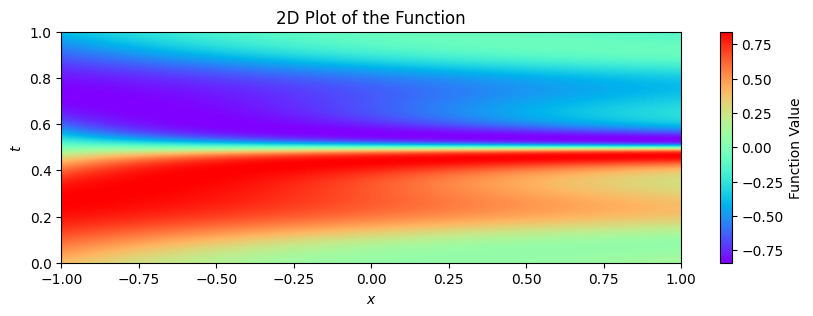

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define the grid
t_values = np.linspace(0, 1, 500)
x_values = np.linspace(-1, 1, 500)
xx, tt = np.meshgrid(x_values, t_values)

# Define the function to plot
def function_to_plot(x, t):
    return -np.sin(np.sin(3.6540537*np.sin(np.sin(x + np.sin(t)*np.sin(2.5981178*np.sin(2.5981178*x))))))

# Evaluate the function over the grid
Z = function_to_plot(xx, tt)

# Plot the function
plt.figure(figsize=(10, 3))
plt.imshow(Z.T, extent=[-1, 1, 0, 1], cmap='rainbow', origin='lower', aspect='auto')
plt.colorbar(label='Function Value')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('2D Plot of the Function')
plt.show()


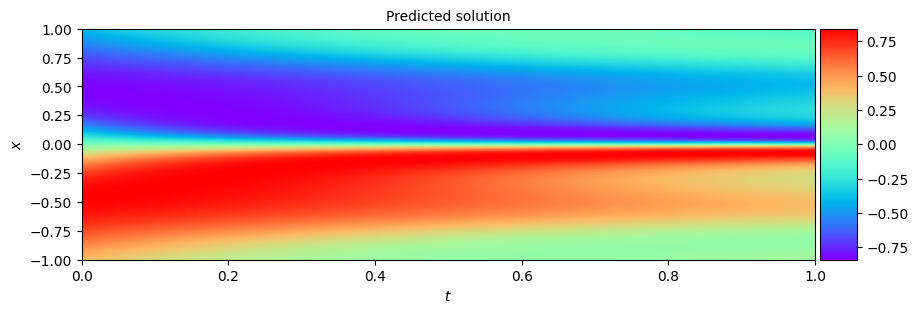

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the grid
t_values = np.linspace(0, 1, 500)
x_values = np.linspace(-1, 1, 500)
xx, tt = np.meshgrid(x_values, t_values)

# Concatenate xx and tt along the columns to form a 2D array
X_grid = np.column_stack((xx.flatten(), tt.flatten()))

# Predict the solution for each point on the grid
U_pred = model.predict(X_grid).reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10, 3))

# Plot the grid
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t_values.min(), t_values.max(), x_values.min(), x_values.max()],
              origin='lower', aspect='auto')

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# Set labels and title
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Predicted solution', fontsize=10)

# Save the plot to a file
plt.savefig('predicted_solution.png')

# If you also want to display the plot (not interactively), you can uncomment the following line:
# plt.show()


In [18]:
# Predict using the model on the normalized features
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_raw)

# Calculate R^2 score
r2 = r2_score(y, y_pred)
print("R^2 score:", r2)
mse=mean_squared_error(y, y_pred)
print("MSE", mse)


R^2 score: 0.9559780269063726
MSE 0.014584350209206566


In [19]:
import sympy as sp
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

# Load your data
df1 = pd.read_csv("/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthEvoPINN/SymbolicReg/BurgerData.csv")


# Extract features and target variable
X_raw = df1[['x', 't']].values
y = df1['U_pred'].values


# Fit the PySR model
model = PySRRegressor(
    niterations=50,
    batching=True,
    batch_size=264,
    fast_cycle=True,
    binary_operators=["+", "*"],
    unary_operators=["cos", "exp", "sin"],
    populations=100,
    model_selection='best',)
model.fit(X_raw, y)

/home/trl102/miniconda3/envs/tf/lib/python3.9/site-packages/pysr/sr.py:1302: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.170e+01
Head worker occupation: 2.4%
Progress: 4 / 5000 total iterations (0.080%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           3.330e-01  7.971e+00  y = sin(0.038181)
3           2.168e-01  4.290e-01  y = x₀ * -0.70719
4           2.084e-01  3.932e-02  y = sin(x₀ * -0.70719)
5           1.974e-01  5.462e-02  y = sin(sin(x₀) * -0.70719)
6           1.816e-01  8.329e-02  y = sin(sin(sin(x₀ * -1.7672)))
7           1.588e-01  1.341e-01  y = sin(sin((x₀ + -1.7672) * x₀))
8           6.256e-02  9.315e-01  y = sin(sin(sin((x₀ + x₀) * -1.7672)))
12          3.953e-02  1.148e-01  y = sin(sin(sin((x₀ * (-0.87761 * exp(cos(x₀)))) * 2.0476)))
19          3.845e-02  3.959e-03  y = sin(sin((-1.825 * 1.094) * (sin(1.6334 * (x₀ + sin(x₀ + x₀...
                                  ))) * sin(exp(-0.47471)))))
20          3.554e-02  7.882e-02  y = 

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                     -0.00034279577   
	1         0.000015                                     sin(-3.138892)   
	2         0.443481                                   x0 * -0.59504664   
	3         0.848838                               sin(-3.5090427 * x0)   
	4         0.288285                          sin(sin(-3.4603462 * x0))   
	5         0.208277                     sin(sin(sin(x0) * -3.9615722))   
	6         0.133464                sin(sin(-4.3715053 * sin(sin(x0))))   
	7         0.150671          sin(sin(sin(x0 * 1.692226) * -3.0041873))   
	8         0.086803       sin(sin((1.1921155 + x1) * x0) * -3.0803697)   
	9         0.262650  sin(sin(-3.0803697 * sin(x0 * (x1 + 1.1740485))))   
	10        0.176840  sin(sin(-3.6273084 * sin(sin(x0 * (1.0891172 +...   
	11        0.082161  sin(sin(-4.088103 * sin(sin(sin(x0 * (x1 + 1.0...   
	12        0.040998  sin(sin(-4.5036764 * sin(sin(sin(sin(x0 * (0.9...   
	13        0.017693  sin(sin(-4.473076 * sin(sin(sin(sin(x0 + (sin(...   
	14        0.063282  sin(sin(-3.5856934 * sin(sin((x1 * sin(sin(2.2...   
	15        0.066117  sin(sin(-3.663702 * sin(sin(x0 + (sin(sin(sin(...   
	16        0.097181  sin(-3.663702 * sin(sin(x0 + (sin(sin(2.562861...   
	17  >>>>  0.235353  sin(sin(-3.663702 * sin(sin(x0 + (sin(sin(2.56...   
	18        0.174676  sin(sin(-3.6981466 * sin(sin((sin(sin(2.562861...   
	19        0.105541  sin(sin(-3.7290564 * sin(sin(x0 + (sin(x1) * s...   
	
	        loss  complexity  
	0   0.331302           1  
	1   0.331297           2  
	2   0.212626           3  
	3   0.090985           4  
	4   0.068198           5  
	5   0.055375           6  
	6   0.048457           7  
	7   0.041679           8  
	8   0.038214           9  
	9   0.029387          10  
	10  0.024624          11  
	11  0.022681          12  
	12  0.021770          13  
	13  0.021389          14  
	14  0.020077          15  
	15  0.018792          16  
	16  0.017052          17  
	17  0.013476          18  
	18  0.011316          19  
	19  0.010183          20  
]

In [20]:
# Predict using the model on the normalized features
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_raw)

# Calculate R^2 score
r2 = r2_score(y, y_pred)
print("R^2 score:", r2)
mse=mean_squared_error(y, y_pred)
print("MSE", mse)

R^2 score: 0.9593230732655424
MSE 0.013476146188809598


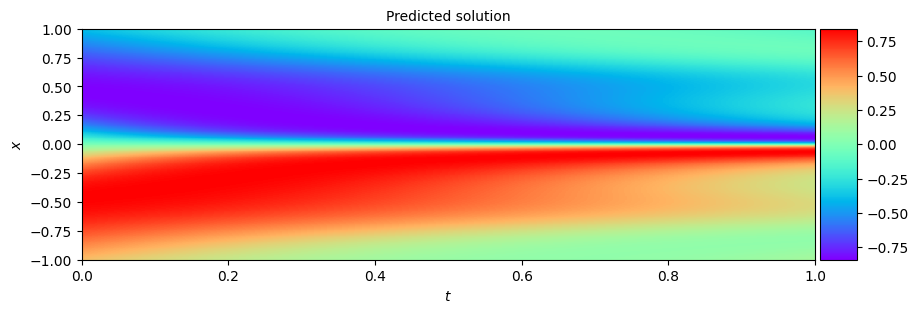

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the grid
t_values = np.linspace(0, 1, 500)
x_values = np.linspace(-1, 1, 500)
xx, tt = np.meshgrid(x_values, t_values)

# Concatenate xx and tt along the columns to form a 2D array
X_grid = np.column_stack((xx.flatten(), tt.flatten()))

# Predict the solution for each point on the grid
U_pred = model.predict(X_grid).reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10, 3))

# Plot the grid
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t_values.min(), t_values.max(), x_values.min(), x_values.max()],
              origin='lower', aspect='auto')

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# Set labels and title
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Predicted solution', fontsize=10)

# Save the plot to a file
plt.savefig('predicted_solution.png')

# If you also want to display the plot (not interactively), you can uncomment the following line:
# plt.show()

In [22]:
model.sympy()

-sin(sin(3.663702*sin(sin(x0 + x1*sin(sin(2.5628617*sin(2.5628617*x0)))))))